In [1]:
import acgan
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
BATCH_SIZE = 128
acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'
session = tf.InteractiveSession()


In [2]:
#tfds.list_builders()

In [3]:
dataset, info = acgan.data.load_celeb_a(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()

Instructions for updating:
Colocations handled automatically by placer.


W0328 03:47:05.631395 140558723213120 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
input_shape

[None, 64, 64, 3]

In [5]:
model = acgan.model.DCGAN(
    embedding_size=100,
    generator={'init_shape':(4, 4, 256),
               'units': [1024, 512, 256, 128, 3],
               'kernels': [(3, 3), (3, 3), (4, 4), (4, 4), (4, 4)],
               'strides': [(1, 1), (2, 2), (2, 2), (2, 2), (2, 2)],
               'padding': ['same', 'same', 'same', 'same', 'same']},
    discriminator={'units':[64, 128, 256, 512],
                   'kernels':4,
                   'strides':2,
                   'dropout':0.05}
)
model.noise_rate.init(rate=0.001)

In [6]:
model.generator.compute_output_shape(input_shape = [None, 100])

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(3)])

In [7]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

gen = model.generator_trainer(BATCH_SIZE, learning_rate=0.0001)
#dis = model.discriminator_trainer(BATCH_SIZE, input_shape[1:])
dis = model.discriminator_trainer(BATCH_SIZE, xreal=xreal, learning_rate=0.0002)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0328 03:47:10.013707 140558723213120 deprecation.py:506] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


W0328 03:47:10.268639 140558723213120 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


W0328 03:47:10.326979 140558723213120 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [8]:
tdl.core.variables_initializer(gen.variables).run()
tdl.core.variables_initializer(dis.variables).run()
#tf.global_variables_initializer().run()

In [9]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 0 | dis 0.684177815914154 | gen 0.6930438280105591


In [16]:
def print_losses():
    print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )
def large_difference(net1, net2, mul):
    n_eval = 1
    loss1 = sum(net1.loss.eval() for i in range(n_eval))/n_eval
    loss2 = sum(net2.loss.eval() for i in range(n_eval))/n_eval
    return mul*loss1 < loss2 
try:
    dis_loss, gen_loss = session.run([dis.loss, gen.loss])
    for i in tqdm.tqdm(range(5000)):
        if (gen_loss) < dis_loss:
            _, dis_loss, gen_loss = session.run([dis.step, dis.loss, gen.loss])
        # if (0.0001*dis_loss) < gen_loss:
        _, dis_loss, gen_loss = session.run([gen.step, dis.loss, gen.loss])
        if i%100 == 0:
            print_losses()
except KeyboardInterrupt:
    pass

  0%|          | 2/5000 [00:00<17:34,  4.74it/s]

step 446 | dis 0.687126636505127 | gen 0.7023592591285706


  2%|▏         | 102/5000 [00:16<15:32,  5.25it/s]

step 456 | dis 0.6753208637237549 | gen 0.748211681842804


  4%|▍         | 202/5000 [00:32<13:33,  5.90it/s]

step 467 | dis 0.6826936602592468 | gen 0.6917637586593628


  6%|▌         | 302/5000 [00:48<13:04,  5.99it/s]

step 477 | dis 0.6909065246582031 | gen 0.7083650827407837


  8%|▊         | 401/5000 [01:04<14:01,  5.46it/s]

step 486 | dis 0.7162888050079346 | gen 0.6171266436576843


 10%|█         | 502/5000 [01:20<12:23,  6.05it/s]

step 499 | dis 0.6991316080093384 | gen 0.6972283124923706


 12%|█▏        | 602/5000 [01:36<13:31,  5.42it/s]

step 511 | dis 0.6434008479118347 | gen 0.7772851586341858


 14%|█▍        | 702/5000 [01:53<12:41,  5.64it/s]

step 524 | dis 0.6790461540222168 | gen 0.7493481040000916


 16%|█▌        | 802/5000 [02:09<13:39,  5.12it/s]

step 534 | dis 0.6643816232681274 | gen 0.7205684185028076


 18%|█▊        | 902/5000 [02:25<11:29,  5.94it/s]

step 544 | dis 0.6935399770736694 | gen 0.7275205850601196


 20%|██        | 1002/5000 [02:41<12:44,  5.23it/s]

step 554 | dis 0.6495198011398315 | gen 0.713458776473999


 22%|██▏       | 1102/5000 [02:56<10:39,  6.10it/s]

step 563 | dis 0.7002143859863281 | gen 0.6999847888946533


 24%|██▍       | 1202/5000 [03:13<11:13,  5.64it/s]

step 576 | dis 0.6969316005706787 | gen 0.7554052472114563


 26%|██▌       | 1302/5000 [03:29<11:27,  5.38it/s]

step 587 | dis 0.6640552282333374 | gen 0.7256343364715576


 28%|██▊       | 1402/5000 [03:45<10:14,  5.86it/s]

step 599 | dis 0.6912844777107239 | gen 0.7041546702384949


 30%|███       | 1502/5000 [04:01<11:11,  5.21it/s]

step 612 | dis 0.6942606568336487 | gen 0.7611600160598755


 32%|███▏      | 1602/5000 [04:18<09:36,  5.90it/s]

step 624 | dis 0.6855332255363464 | gen 0.7028003931045532


 34%|███▍      | 1701/5000 [04:34<10:00,  5.49it/s]

step 636 | dis 0.7155628204345703 | gen 0.6360076665878296


 36%|███▌      | 1802/5000 [04:50<09:30,  5.61it/s]

step 648 | dis 0.652755081653595 | gen 0.7541705369949341


 38%|███▊      | 1902/5000 [05:06<08:47,  5.88it/s]

step 659 | dis 0.6903382539749146 | gen 0.7166182398796082


 40%|████      | 2002/5000 [05:22<09:09,  5.46it/s]

step 672 | dis 0.6864821314811707 | gen 0.7278167605400085


 42%|████▏     | 2102/5000 [05:38<08:49,  5.48it/s]

step 681 | dis 0.686600923538208 | gen 0.7351900339126587


 44%|████▍     | 2202/5000 [05:55<07:52,  5.93it/s]

step 695 | dis 0.7032906413078308 | gen 0.7237633466720581


 46%|████▌     | 2302/5000 [06:11<07:47,  5.77it/s]

step 704 | dis 0.6864708662033081 | gen 0.6966575980186462


 48%|████▊     | 2402/5000 [06:27<07:29,  5.78it/s]

step 719 | dis 0.6944648027420044 | gen 0.7257804870605469


 50%|█████     | 2502/5000 [06:43<06:54,  6.03it/s]

step 729 | dis 0.6839630007743835 | gen 0.6991879940032959


 52%|█████▏    | 2602/5000 [06:59<07:06,  5.62it/s]

step 742 | dis 0.6744204759597778 | gen 0.7109383344650269


 54%|█████▍    | 2701/5000 [07:15<07:27,  5.13it/s]

step 753 | dis 0.7422502636909485 | gen 0.600994884967804


 56%|█████▌    | 2802/5000 [07:32<06:44,  5.44it/s]

step 764 | dis 0.6923700571060181 | gen 0.7380103468894958


 58%|█████▊    | 2902/5000 [07:48<05:58,  5.86it/s]

step 777 | dis 0.6903144121170044 | gen 0.6961886882781982


 60%|██████    | 3002/5000 [08:04<05:36,  5.93it/s]

step 786 | dis 0.6800264120101929 | gen 0.6972974538803101


 62%|██████▏   | 3102/5000 [08:20<05:35,  5.65it/s]

step 800 | dis 0.6964649558067322 | gen 0.7287346124649048


 64%|██████▍   | 3202/5000 [08:37<05:17,  5.66it/s]

step 815 | dis 0.6916351318359375 | gen 0.7441837787628174


 66%|██████▌   | 3302/5000 [08:53<04:47,  5.91it/s]

step 827 | dis 0.6829341650009155 | gen 0.6916152834892273


 68%|██████▊   | 3402/5000 [09:09<04:36,  5.78it/s]

step 840 | dis 0.6833895444869995 | gen 0.7208142280578613


 70%|███████   | 3502/5000 [09:26<04:12,  5.93it/s]

step 853 | dis 0.6871920824050903 | gen 0.7044591307640076


 72%|███████▏  | 3602/5000 [09:42<03:52,  6.02it/s]

step 866 | dis 0.679398238658905 | gen 0.6836142539978027


 74%|███████▍  | 3702/5000 [09:58<03:35,  6.02it/s]

step 879 | dis 0.703795850276947 | gen 0.711524486541748


 76%|███████▌  | 3802/5000 [10:14<03:18,  6.04it/s]

step 890 | dis 0.6904169917106628 | gen 0.6940204501152039


 78%|███████▊  | 3902/5000 [10:31<03:00,  6.08it/s]

step 904 | dis 0.714678168296814 | gen 0.718930721282959


 80%|████████  | 4002/5000 [10:47<02:52,  5.77it/s]

step 914 | dis 0.6834590435028076 | gen 0.6927708387374878


 82%|████████▏ | 4102/5000 [11:03<02:27,  6.09it/s]

step 922 | dis 0.7115908861160278 | gen 0.7068047523498535


 84%|████████▍ | 4202/5000 [11:19<02:21,  5.62it/s]

step 936 | dis 0.6812174320220947 | gen 0.7119117379188538


 86%|████████▌ | 4302/5000 [11:35<02:07,  5.46it/s]

step 949 | dis 0.6788345575332642 | gen 0.7278734445571899


 88%|████████▊ | 4402/5000 [11:51<01:54,  5.22it/s]

step 958 | dis 0.6865629553794861 | gen 0.7328108549118042


 90%|█████████ | 4502/5000 [12:07<01:31,  5.46it/s]

step 970 | dis 0.6332933902740479 | gen 0.7269759178161621


 92%|█████████▏| 4602/5000 [12:24<01:07,  5.93it/s]

step 987 | dis 0.6824153661727905 | gen 0.7380369901657104


 94%|█████████▍| 4702/5000 [12:40<00:50,  5.92it/s]

step 994 | dis 0.6975957155227661 | gen 0.689231276512146


 96%|█████████▌| 4802/5000 [12:56<00:34,  5.76it/s]

step 1006 | dis 0.6613655090332031 | gen 0.733914852142334


 98%|█████████▊| 4902/5000 [13:12<00:16,  6.10it/s]

step 1014 | dis 0.708346426486969 | gen 0.7249416708946228


100%|██████████| 5000/5000 [13:28<00:00,  6.80it/s]


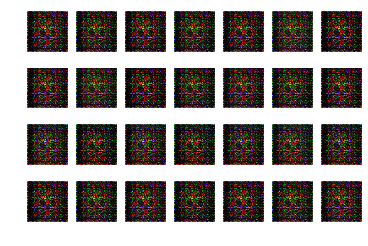

In [19]:
import matplotlib.pyplot as plt
import numpy as np
xsim = dis.x.eval()
for i in range(4*7):
    plt.subplot(4,7, i+1)
    plt.imshow(np.squeeze((xsim[i][:,:,:]+1)*0.5))
    plt.axis('off')